In [8]:
import torch
import torchvision
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from tqdm import tqdm
from lsc import LangevinSparseCoding
from torch.utils.data import DataLoader

from sparsecoding.visualization import plot_dictionary 
from sparsecoding.data.transforms.patch import sample_random_patches

In [9]:
def generate_bars_basis(patch_size:int=12):
    basis_images = np.zeros([2*patch_size,patch_size,patch_size])
    for i in range(patch_size):
        basis_images[i,i,:] = 1
        
    for i in range(patch_size):
        basis_images[i+patch_size,:,i] = 1

    dict = basis_images.reshape([2*patch_size,patch_size**2]).T
    dict = dict/np.linalg.norm(dict,axis=0,keepdims=True)
        
    return dict

In [10]:
patch_size = 4
n_features = patch_size**2
n_latent = 2*patch_size
sparsity_penalty = 1.0
var = 1/sparsity_penalty
temperature = 1
mass = 1
NOISE_MEAN, NOISE_STD = 0 , 0.05

dataset_size = int(5e4)
batch_size = 500

Text(0.5, 1.0, 'Generated data\n$\\lambda=1$; $\\sigma^2=5.0e-02$')

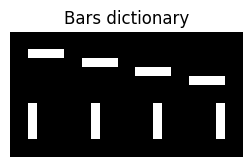

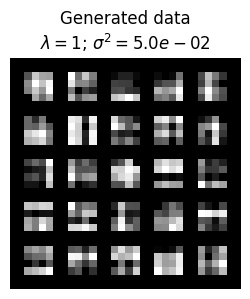

In [11]:
C = lambda s: s.abs().sum()
Cprime = lambda s: torch.sign(s)

Abars = torch.FloatTensor(generate_bars_basis(patch_size=patch_size))

distribution = torch.distributions.Laplace(0.0, var)
s_star = distribution.sample(sample_shape=[dataset_size,n_latent])
x = (Abars@s_star.T).T + np.sqrt(NOISE_STD)*torch.FloatTensor(size=[dataset_size,n_features]).normal_()+NOISE_MEAN

dl = DataLoader(
    x,
    batch_size=batch_size,
    shuffle=True
)

fig,ax = plot_dictionary(Abars,nrow=4,size=3)
ax.set_title('Bars dictionary')

fig,ax = plot_dictionary(x[0:25,:].T,nrow=5,size=3,normalize=True,scale_each=True)
ax.set_title('Generated data\n$\lambda=%.0f$; $\sigma^2=%.1e$'%(sparsity_penalty,NOISE_STD))


In [12]:
def compute_map(x,lsc:LangevinSparseCoding,n_iterations:int):
    batch_size = x.shape[0]
    s_map = torch.zeros([batch_size,lsc.n_latent])

    for n in (range(n_iterations)):
        # warm start at map estimate
        ds = lsc.dt*lsc.energy_grad(x,s_map)
        s_map -= torch.clone(ds)
    return s_map

In [28]:
n_epoch = int(40)
n_samples = int(7e2)
n_warm_start = int(3e2)

dt = 1e-3
dict_lr = 1e-3

lsc = LangevinSparseCoding(
    n_features=n_features,
    n_latent=n_latent,
    sparsity_penaly=sparsity_penalty,
    temperature=temperature,
    dt=dt,
    cost_function=C,
    cost_function_grad=Cprime,
    mass=mass,
    gauss_std=NOISE_STD,
)
# lsc.A = Abars
e = []
s_samples = torch.empty([batch_size, n_samples, n_latent])
for i in tqdm(range(n_epoch)):
    for batch in dl:
        # compute map estimate as warm start
        s_map = compute_map(batch,lsc,n_warm_start)

        s = torch.clone(s_map)
        v = torch.zeros_like(s_map) 
        # sample posterior
        for n in range(n_samples):        
            
            # -- second order update --
            ds,dv = lsc.second_order_langevin_update(batch,s,v)
            s += torch.clone(ds)
            v += torch.clone(dv)
            s_samples[:,n,:] = torch.clone(s)
        # update dictionary
        dA = lsc.dictionary_grad(batch,s_samples.mean(dim=1))
        # dA = lsc.dictionary_grad(batch,s_map)
        lsc.A += dict_lr*dA
        lsc.normalize_dictionary()
        e.append(lsc.energy(batch,s_map).mean().item())


100%|██████████| 40/40 [06:01<00:00,  9.05s/it]


Text(0, 0.5, 'energy')

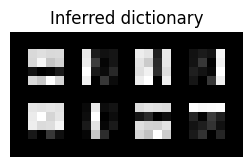

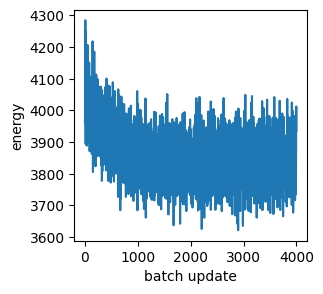

In [29]:
fig,ax = plot_dictionary(lsc.A,nrow=4,size=3)
ax.set_title('Inferred dictionary')

fig,ax = plt.subplots(figsize=(3,3))
ax.plot(e)
ax.set_xlabel('batch update')
ax.set_ylabel('energy')

In [25]:
lsc.A.norm(dim=0).shape

torch.Size([8])